In [2]:
import os
import sys
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import carla

In [3]:
#Configs
MAP = ['circut_spa', 'RaceTrack', 'RaceTrack2']

client = carla.Client('localhost', 2000)
client.set_timeout(10.0) # seconds

In [6]:
world = client.load_world(MAP[2])
blueprint_library = world.get_blueprint_library() 

In [4]:
spawn_points = world.get_map().get_spawn_points()

spawn_points_df = pd.DataFrame().from_dict({idx: (sp.location.x, sp.location.y, sp.location.z) 
                                            for idx, sp in enumerate(spawn_points)}).T

spawn_points_df.rename(columns={0:'x', 1:'y', 2:'z'}, inplace=True)

In [5]:
spawn_points_df.shape

(56, 3)

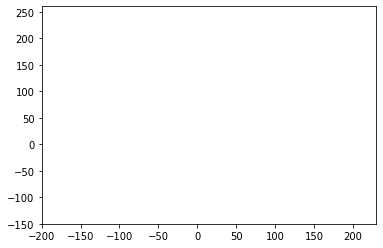

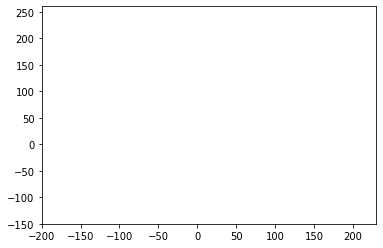

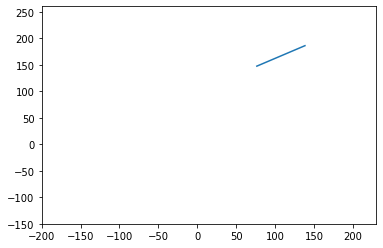

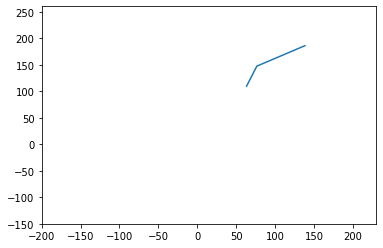

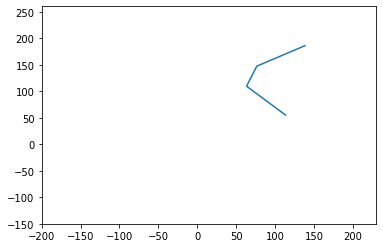

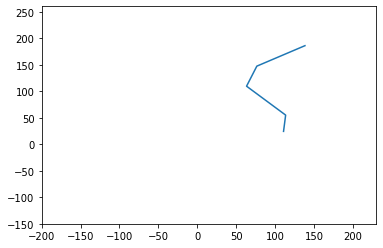

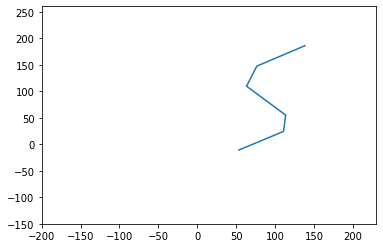

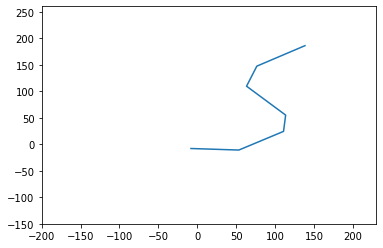

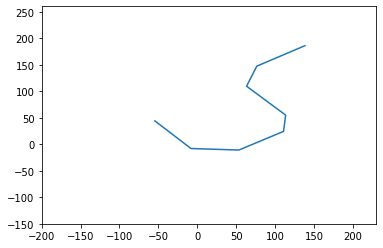

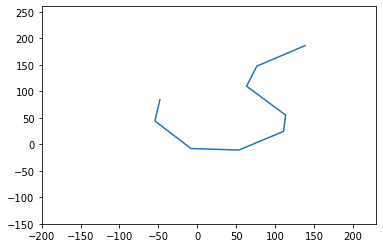

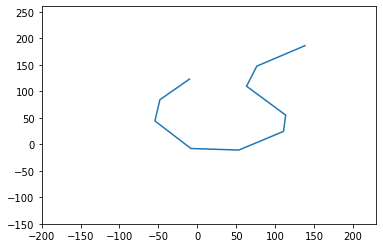

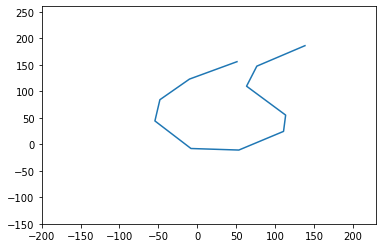

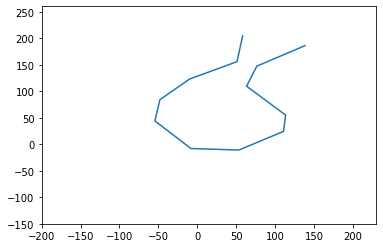

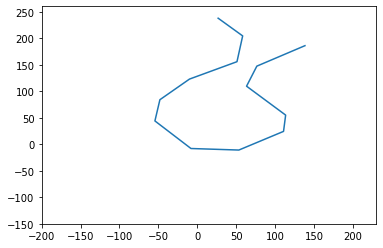

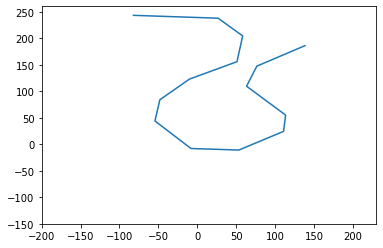

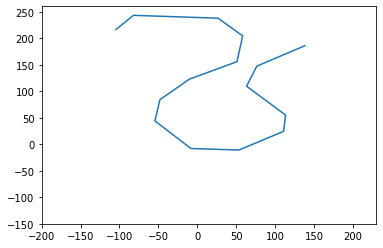

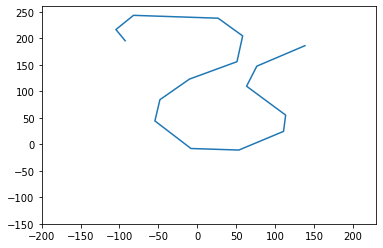

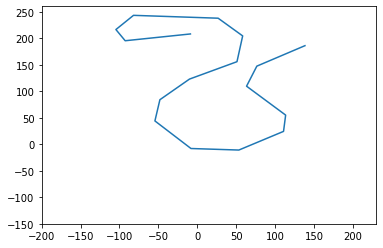

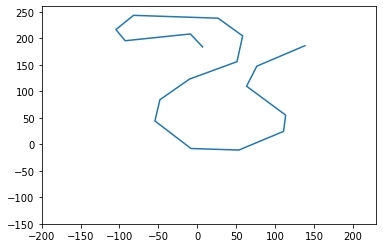

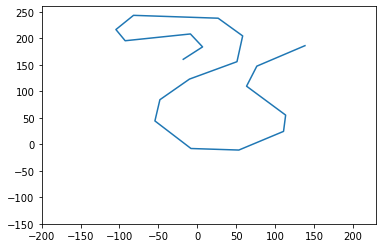

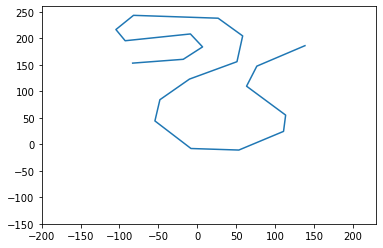

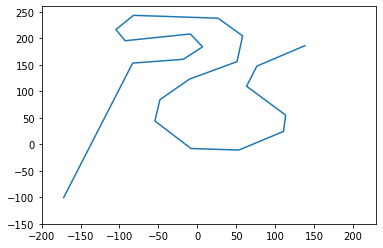

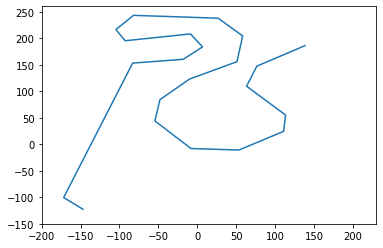

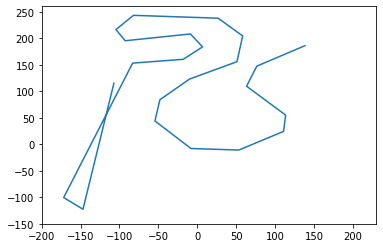

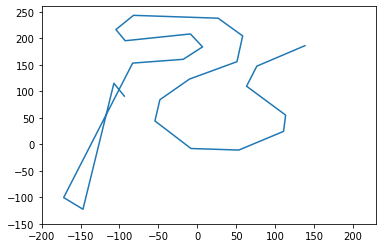

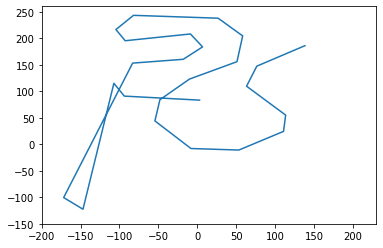

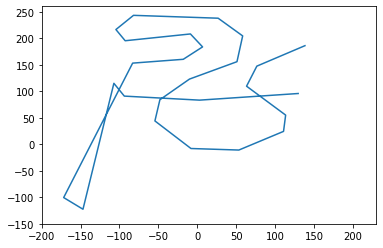

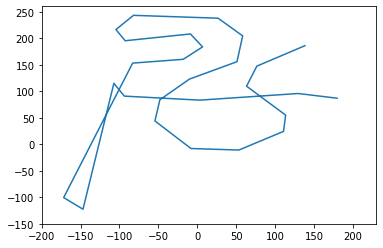

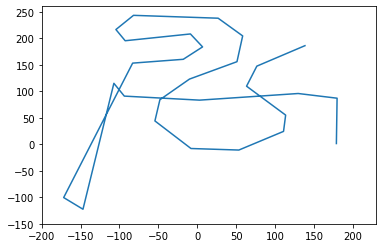

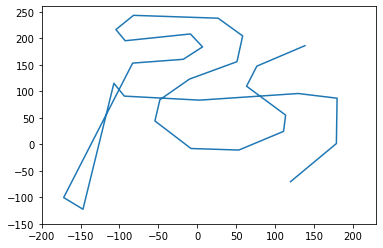

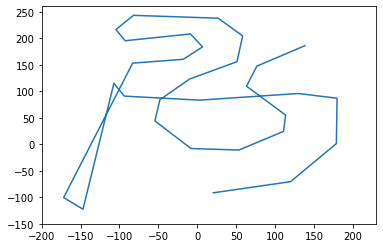

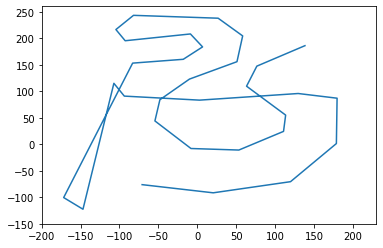

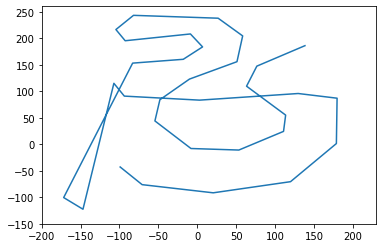

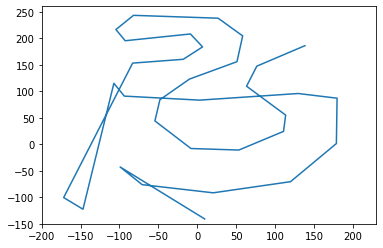

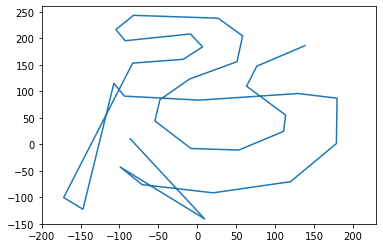

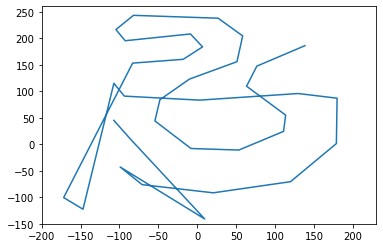

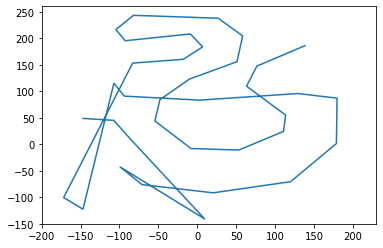

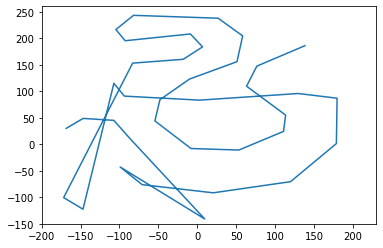

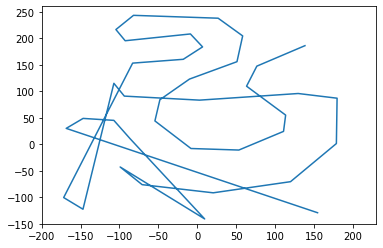

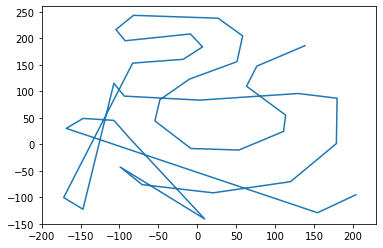

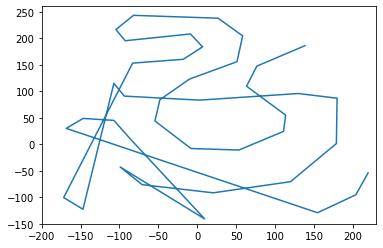

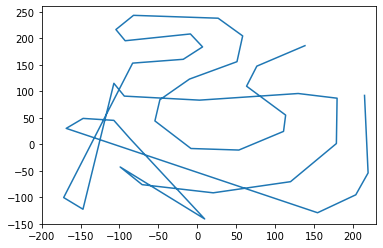

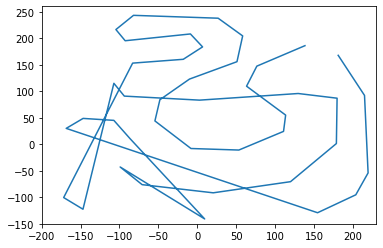

In [14]:
for i in range(len(spawn_points)):
    plt.plot(spawn_points_df['x'][:i], spawn_points_df['y'][:i])
    plt.xlim([-200,230])
    plt.ylim([-150, 260])
    plt.show()

In [26]:
bp = blueprint_library.filter('audi')[2]

In [12]:
# nie używ
x,y,z, pitch, roll, yaw =  'x' , 'y' , 'z' , 'pitch' , 'roll' , 'yaw'

In [9]:
x,y,z, pitch, yaw, roll = 172.2768096923828,71.26828002929688,-74.45903015136719,0.0,0.0,159.99984741210938
a = carla.Transform(carla.Location(x,y,z), carla.Rotation(pitch, roll, yaw))
vehicle = world.spawn_actor(bp, a)
time.sleep(5)
vehicle.destroy()

NameError: name 'bp' is not defined

In [240]:
i = 56
vehicle = world.spawn_actor(bp, spawn_points[i])
x,y,z = spawn_points[i].location.x,  spawn_points[i].location.y, spawn_points[i].location.z
pitch, roll, yaw = spawn_points[i].rotation.pitch,  spawn_points[i].rotation.roll, spawn_points[i].rotation.yaw
x

IndexError: list index out of range

In [239]:
vehicle.destroy()

False

In [233]:
with open('../../data/spawn_points/RaceTrack.csv', 'a') as file:
    file.write(f'{x},{y},{z},{pitch},{roll},{yaw}\n')

In [ ]:
20, 21, dolny lewy przed zakrętem 32 pol zakretu 43 wyjscie z zakretu